In [1]:
import geopandas as gpd
import pandas as pd
import os
import getpass
import matplotlib.pyplot as plt

### NOTES:


###### Bring in necessary geojson files and set your projection for all files

In [2]:
wd = os.getcwd()
wd = wd[:wd.find('notebooks')]

#crs is set for Central Texas; https://epsg.io/6578; 
crs =  {'init' :'epsg:6578'}

parks = gpd.read_file(wd+"data/coaparks/parkboundaries.geojson")
parks = parks.to_crs(crs).explode().reset_index()

varibuff = gpd.read_file(wd+"data/coaparks_buffer/varibuff.shp")
varibuff.crs={'init' :'epsg:6578'}

pop = gpd.read_file(wd+"data/blockgroups_censusdata/popmerge.shp")
pop = pop.to_crs(crs).reset_index()

race = gpd.read_file(wd+"data/blockgroups_censusdata/racemerge.shp")
race = race.to_crs(crs).reset_index()

income = gpd.read_file(wd+"data/blockgroups_censusdata/incomemerge.shp")
income = income.to_crs(crs).reset_index()

age = gpd.read_file(wd+"data/blockgroups_censusdata/agemerge.shp")
age = age.to_crs(crs).reset_index()


##### Check your projections
https://geopandas.org/projections.html

In [3]:
#varibuff.crs

In [4]:
#pop.crs

In [5]:
#race.crs

In [6]:
#age.crs

###### Preview the files and clean the data

In [7]:
pop['fullarea_pop'] = pop['geometry'].area
#pop.head()

In [8]:
race['fullarea_race'] = race['geometry'].area
#race.head()

In [9]:
income['fullarea_income'] = income['geometry'].area
#income.head()

In [10]:
age['fullarea_age'] = age['geometry'].area
#age.head()

In [11]:
varibuff['fullarea_buff'] = varibuff['geometry'].area
#varibuff.head()

### Run spatial analysis using 'difference' to calculate who is not served by a park

In [27]:
park_dif = parks.copy()
vbuff = varibuff.copy().explode()
race_dif = race.copy()
income_dif = income.copy()
age_dif = age.copy()

race_difference = gpd.overlay(race_dif, park_dif, how='difference')
income_difference = gpd.overlay(income_dif, park_dif, how='difference')
age_difference = gpd.overlay(age_dif, park_dif, how='difference')

In [29]:
vbuff.head()

,,ASSET_MGMT,LOCATION_N,ADDRESS,CITY_MUNIC,COUNTY,STATE,STREET_NUM,STREET_NAM,STREET_TYP,ZIPCODE,...,MXLOADID,GLOBALID,CREATED_BY,CREATED_DA,MODIFIED_B,MODIFIED_D,Shape__Are,Shape__Len,fullarea_buff,geometry
0,0,412,Stratford Overlook Greenbelt,"3006 Stratford Dr., Austin, Texas 78746",Austin,Travis,TX,3006,Stratford,Dr.,78746,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,4403.261719,420.672106,3.283968e+08,"POLYGON ((3093382.105579928 10068110.4697226, ..."
1,0,413,Highland Neighborhood Park,"403 W St Johns Ave., Austin, Texas 78752",Austin,Travis,TX,403,W St Johns,Ave.,78752,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,10487.996094,422.279483,6.005148e+06,"POLYGON ((3122096.607847079 10096622.97796875,..."
2,0,354,Palma Plaza Pocket Park,"1524 Palma Plz., Austin, Texas 78703",Austin,Travis,TX,1524,Palma,Plz,78703,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,10076.777344,492.661534,5.758054e+06,"POLYGON ((3110880.480735413 10075707.57567622,..."
3,0,398,Oertli Neighborhood Park,"12613 Blaine Rd., Austin, Texas 78753",Austin,Travis,TX,12613,Blaine,Rd.,78753,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,267188.275391,2404.916487,9.878700e+07,"POLYGON ((3139954.891922666 10112725.14427203,..."
4,0,364,Peace Point at Town Lake Metro Park,"2200 S Lakeshore Blvd., Austin, Texas 78741",Austin,Travis,TX,2200,S Lakeshore,Blvd,78741,...,None,None,CTM.Publisher,2019-10-12,CTM.Publisher,2019-10-12,238128.056641,4343.236948,9.320615e+07,"POLYGON ((3125344.080527302 10059285.06139334,..."


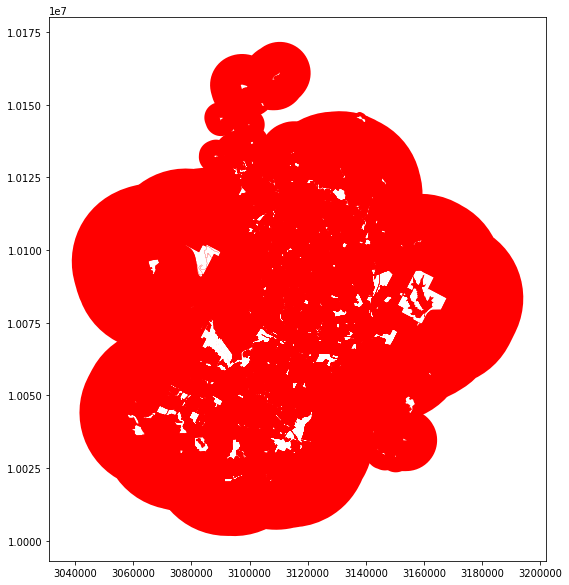

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
vbuff.plot(ax = ax, color='red');

In [32]:
vbuff_diss = vbuff.dissolve(by='STATE')

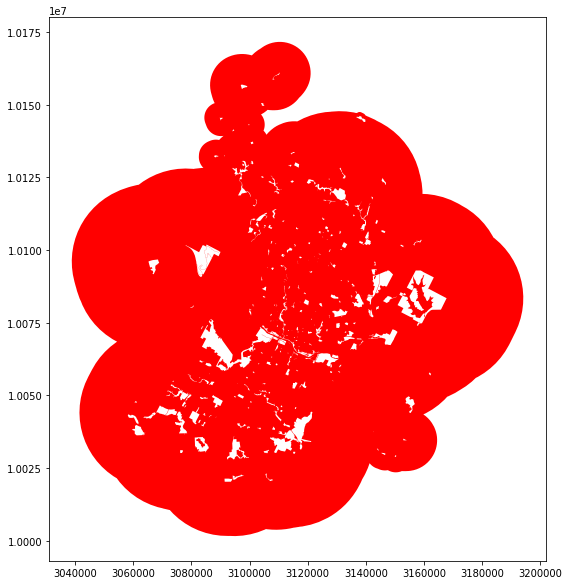

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
vbuff_diss.plot(ax = ax, color='red');

In [34]:
race_difference = gpd.overlay(race_difference, vbuff_diss, how='difference')
income_difference = gpd.overlay(income_difference, vbuff_diss, how='difference')
age_difference = gpd.overlay(age_difference, vbuff_diss, how='difference')

In [35]:
race_ns = race_difference[[ 'GEOID10','Total_POP_', 'Not Hisp_1', 'White; N_1', 'Hispanic_1', 'fullarea_race','geometry']]

race_ns['new_area'] = race_ns['geometry'].area
race_ns['area_acre'] = (race_ns['new_area']/43560)

for val in race_ns:

    race_ns['weight'] = race_ns['new_area']/ race_ns['fullarea_race']
    
    race_ns['TotPopNS'] = (race_ns['weight'] * race_ns['Total_POP_']).astype(int)
    race_ns['NotHisNS'] = (race_ns['weight'] * race_ns['Not Hisp_1']).astype(int)
    race_ns['WhiteNS'] = (race_ns['weight'] * race_ns['White; N_1']).astype(int)
    race_ns['HispanNS'] = (race_ns['weight'] * race_ns['Hispanic_1']).astype(int)

race_ns['Norm_byArea'] = race_ns['TotPopNS']/race_ns['area_acre']
race_ns['Norm_nonhis'] = race_ns['NotHisNS']/race_ns['area_acre']
race_ns['Norm_white'] = race_ns['WhiteNS']/race_ns['area_acre']
race_ns['Norm_hislat'] = race_ns['HispanNS']/race_ns['area_acre']

race_ns.to_file(wd+"data/access/noaccess_race_varibuff_ACS17.shp")
race_ns.head()

notserved_racetable = race_ns.drop(columns=['geometry'])
notserved_racetable.to_csv(wd+"data/access/noaccess_table_race_varibuff_ACS17_ACS17.csv")

Race_noaccess_stats = notserved_racetable.describe()
Race_noaccess_stats.to_csv(wd+"data/access/stats_race_varibuff_ACS17ACS17.csv")

C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be 

In [36]:
income_ns = income_difference[[ 'GEOID10','Total_POP_', 'Less tha_1', '$10,000 _1', '$15,000 _1','$20,000 _1', '$25,000 _1', 
                               '$30,000 _1', '$35,000 _1', '$40,000 _1','$45,000 _1', '$50,000 _1', '$60,000 _1', 
                               '$75,000 _1', '$100,000_1','$125,000_1', '$150,000_1', '$200,000_1', 'fullarea_income',
                               'geometry']]

income_ns['new_area'] = income_ns['geometry'].area
income_ns['area_acre'] = (income_ns['new_area']/43560)

for val in income_ns:

    income_ns['weight'] = income_ns['new_area']/ income_ns['fullarea_income']
    
    income_ns['TotPopNS'] = income_ns['weight'] * income_ns['Total_POP_']
    
    income_ns['Lessthan25,000'] = ((income_ns['weight'] * income_ns['Less tha_1'])\
                                        +(income_ns['weight'] * income_ns['$10,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$15,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$20,000 _1'])).astype(int)
    
    income_ns['25,000to49,999'] = ((income_ns['weight'] * income_ns['$25,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$30,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$35,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$40,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$45,000 _1'])).astype(int)
    
    income_ns['50,000to74,999'] = ((income_ns['weight'] * income_ns['$50,000 _1'])\
                                        +(income_ns['weight'] * income_ns['$60,000 _1'])).astype(int)
    
    income_ns['75,000to99,999'] = (income_ns['weight'] * income_ns['$75,000 _1']).astype(int)
    
    income_ns['100,000to149,999'] = ((income_ns['weight'] * income_ns['$100,000_1'])\
                                            +(income_ns['weight'] * income_ns['$125,000_1'])).astype(int)
    
    income_ns['150,000ormore'] = ((income_ns['weight'] * income_ns['$150,000_1'])\
                                        +(income_ns['weight'] * income_ns['$200,000_1'])).astype(int)
    
income_ns['Norm_TotPopNS'] = income_ns['TotPopNS']/income_ns['area_acre']
income_ns['Norm_Lessthan25,000'] = income_ns['Lessthan25,000']/income_ns['area_acre']
income_ns['Norm_25,000to49,999'] = income_ns['25,000to49,999']/income_ns['area_acre']
income_ns['Norm_50,000to74,999'] = income_ns['50,000to74,999']/income_ns['area_acre']
income_ns['Norm_75,000to99,999'] = income_ns['75,000to99,999']/income_ns['area_acre']
income_ns['Norm_100,000to149,999'] = income_ns['100,000to149,999']/income_ns['area_acre']
income_ns['Norm_150,000ormore'] = income_ns['150,000ormore']/income_ns['area_acre']

income_ns.to_file(wd+"data/access/noaccess_income_varibuff_ACS17_ACS17.shp")
income_ns.head()

notserved_incometable = income_ns.drop(columns=['geometry'])
notserved_incometable.to_csv(wd+"data/access/noaccess_table_income_varibuff_ACS17_ACS17.csv")

income_noaccess_stats = notserved_incometable.describe()
income_noaccess_stats.to_csv(wd+"data/access/stats_income_varibuff_ACS17ACS17.csv")

C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [37]:
age_ns = age_difference[[ 'GEOID10','Total_PO_1', 'Male_new','Male_Und_2', 'Male_Und_3', 'Male_Ove_1', 'Female', 
                         'Female_U_2','Female_U_3', 'Female_O_1', 'fullarea_age','geometry']]

age_ns['new_area'] = age_ns['geometry'].area
age_ns['area_acre'] = (age_ns['new_area']/43560)

for val in age_ns:

    age_ns['weight'] = age_ns['new_area']/ age_ns['fullarea_age']
    
    age_ns['TotPopNS'] = age_ns['weight'] * age_ns['Total_PO_1']
    
    age_ns['Males_ns'] = age_ns['weight'] * age_ns['Male_new']
    age_ns['Males_ns_under5'] = age_ns['weight'] * age_ns['Male_Und_2']
    age_ns['Males_ns_under18'] = age_ns['weight'] * age_ns['Male_Und_3']
    age_ns['Males_ns_over65'] = age_ns['weight'] * age_ns['Male_Ove_1']   
    
    age_ns['Females_ns'] = age_ns['weight'] * age_ns['Female']
    age_ns['Females_ns_under5'] = age_ns['weight'] * age_ns['Female_U_2']
    age_ns['Females_ns_under18'] = age_ns['weight'] * age_ns['Female_U_3']
    age_ns['Females_ns_over65'] = age_ns['weight'] * age_ns['Female_O_1']

age_ns['Under5_ns'] = age_ns['Males_ns_under5'] + age_ns['Females_ns_under5']
age_ns['Under18_ns'] = age_ns['Males_ns_under18'] + age_ns['Females_ns_under18']
age_ns['Over65_ns'] = age_ns['Males_ns_over65'] + age_ns['Females_ns_over65']
age_ns['W_C_under5']= age_ns['Females_ns'] + age_ns['Males_ns_under5']
age_ns['W_C_under18']= age_ns['Females_ns'] + age_ns['Males_ns_under18']


age_ns['Norm_TotPopNS'] = age_ns['TotPopNS']/age_ns['area_acre']

age_ns['Norm_M_ns'] = age_ns['Males_ns']/age_ns['area_acre']
age_ns['Norm_M_ns_un5'] = age_ns['Males_ns_under5']/age_ns['area_acre']
age_ns['Norm_M_ns_un18'] = age_ns['Males_ns_under18']/age_ns['area_acre']
age_ns['Norm_M_ns_ov65'] = age_ns['Males_ns_over65']/age_ns['area_acre']

age_ns['Norm_F_ns'] = age_ns['Females_ns']/age_ns['area_acre']
age_ns['Norm_F_ns_un5'] = age_ns['Females_ns_under5']/age_ns['area_acre']
age_ns['Norm_F_ns_un18'] = age_ns['Females_ns_under18']/age_ns['area_acre']
age_ns['Norm_F_ns_ov65'] = age_ns['Females_ns_over65']/age_ns['area_acre']

age_ns['Norm_Under5'] = age_ns['Under5_ns']/age_ns['area_acre']
age_ns['Norm_Under18'] = age_ns['Under18_ns']/age_ns['area_acre']
age_ns['Norm_Over65_ns'] = age_ns['Over65_ns']/age_ns['area_acre']
age_ns['Norm_W_C_under5']= age_ns['W_C_under5']/age_ns['area_acre']
age_ns['Norm_W_C_under18']= age_ns['W_C_under18'] /age_ns['area_acre']


age_ns.to_file(wd+"data/access/noaccess_age_varibuff_ACS17.shp")
age_ns.head()

notserved_agetable = age_ns.drop(columns=['geometry'])
notserved_agetable.to_csv(wd+"data/access/noaccess_table_age_varibuff_ACS17.csv")

age_noaccess_stats = notserved_agetable.describe()
age_noaccess_stats.to_csv(wd+"data/access/stats_age_varibufff_ACS17.csv")

C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Victoria\Anaconda3\envs\park_env\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

### <font color=green>Run spatial analysis on the amount of people distributed within a census block group against the varied mile park buffer area and the race census data</font>

In [ ]:
rp_intersection = gpd.overlay(race, varibuff, how='intersection') #https://geopandas.org/set_operations.html
rp_intersection['area_intersec'] = rp_intersection['geometry'].area
rp_intersection.to_file(wd+"data/access/rp_intersec_varibuff_ACS17.shp")
rp_intersection

In [ ]:
#rp_intersection.crs

In [ ]:
#rp_intersection.columns

In [ ]:
rp_intersection[['GEOID10','Total_POP_','fullarea_race','LOCATION_N','fullarea_buff','area_intersec','geometry']]

In [ ]:
race_clip=rp_intersection.copy()

for val in race_clip:

    race_clip['weight'] = race_clip['area_intersec']/ race_clip['fullarea_race']
    
    race_clip['access_pop'] = race_clip['weight'] * race_clip['Total_POP_']
    race_clip['access_nonhis'] = race_clip['weight'] * race_clip['Not Hispan']
    race_clip['access_white'] = race_clip['weight'] * race_clip['White; Not']
    race_clip['access_his_lat'] = race_clip['weight'] * race_clip['Hispanic o']

race_clip.head()

In [ ]:
#race_clip.columns

In [ ]:
race_calc = race_clip[['LOCATION_N', 'Total_POP_','access_pop', 'access_nonhis','access_white', 'access_his_lat','area_intersec','geometry']]
access_data = race_calc.dissolve(by='LOCATION_N',as_index=False, aggfunc='sum')

In [ ]:
access_data

##### Combine the park area data to the access data

In [ ]:
parks_ = varibuff[['LOCATION_N','ASSET_SIZE']].copy()

In [ ]:
parks_

In [ ]:
access_data = access_data.merge(parks_, on='LOCATION_N')

In [ ]:
access_data

##### The population served by parks is nomalized by dividing the population served by the area of the park for which they are being served 

In [ ]:
access_data['Normalized_byArea'] = access_data['access_pop']/access_data['ASSET_SIZE']
access_data['Normalized_nonhis'] = access_data['access_nonhis']/access_data['ASSET_SIZE']
access_data['Normalized_white'] = access_data['access_white']/access_data['ASSET_SIZE']
access_data['Normalized_hislat'] = access_data['access_his_lat']/access_data['ASSET_SIZE']

In [ ]:
access_data.to_file(wd+"data/access/access_data_race_varibuff_ACS17.shp")
access_data

#### A dataframe is created with the 'acess_data' geoshapefile. This dataframe is cleaned up and the values are convereted into integers. Finally, we export the dataframe into a csv file and a shapefile. 

In [ ]:
df = pd.DataFrame(access_data)

df['Park_Name']=df['LOCATION_N']
df['Total_Pop_Served'] = df['access_pop'].astype(int)
df['Normalized_byArea'] = df['Normalized_byArea'].astype(int)
df['Non_Hispan'] = df['access_nonhis'].astype(int)
df['Normalized_nonhis'] = df['Normalized_nonhis'].astype(int)
df['White'] = df['access_white'].astype(int)
df['Normalized_white'] = df['Normalized_white'].astype(int)
df['Hispan_Latin'] = df['access_his_lat'].astype(int)
df['Normalized_hislat'] = df['Normalized_hislat'].astype(int)

df.head()


Export to Shapefile

In [ ]:
access_race_final = df.copy().drop(columns=['access_pop','access_nonhis','access_white','access_his_lat'])
access_race_final = gpd.GeoDataFrame(access_race_final, geometry='geometry')
access_race_final.to_file(wd+"data/access/access_race_final_varibuff_ACS17.shp")
access_race_final.head()

Export to CSV

In [ ]:
access_racetable = df.drop(columns=['access_pop','access_nonhis','access_white','access_his_lat', 'geometry'])
access_racetable.to_csv(wd+"data/access/access_table_race_varibuff_ACS17.csv")
access_racetable.head()

Descriptive Statistics

In [ ]:
Race_access_stats = access_racetable.describe()
Race_access_stats.to_csv(wd+"data/access/access_stats_race_varibuff_ACS17.csv")
Race_access_stats

In [ ]:
#access_racetable.hist('');

##  <font color=goldenrod>Run spatial analysis on the amount of people distributed within a census block group against the varied buff mile park buffer area and the income census data</font>

In [ ]:
ip_intersection = gpd.overlay(income, varibuff, how='intersection') #https://geopandas.org/set_operations.html
ip_intersection['iarea_intersec'] = ip_intersection['geometry'].area
ip_intersection.to_file(wd+"data/access/ip_intersec_varibuff_ACS17.shp")
ip_intersection

In [ ]:
#ip_intersection.columns

In [ ]:
ip_intersection[['GEOID10','Total_Pop','fullarea_income','LOCATION_N','fullarea_buff','iarea_intersec','geometry']]

In [ ]:
ip_intersection.columns

In [ ]:
income_clip=ip_intersection.copy()

for val in income_clip:

    income_clip['weight'] = income_clip['iarea_intersec']/ income_clip['fullarea_income']
    
    income_clip['access_by_income_TotalPop'] = income_clip['weight'] * income_clip['Total_Pop']
    
    income_clip['Less than $25,000'] = (income_clip['weight'] * income_clip['Less than'])\
                                        +(income_clip['weight'] * income_clip['$10,000 to'])\
                                        +(income_clip['weight'] * income_clip['$15,000 to'])\
                                        +(income_clip['weight'] * income_clip['$20,000 to'])
    
    income_clip['$25,000 to $49,999'] = (income_clip['weight'] * income_clip['$25,000 to'])\
                                        +(income_clip['weight'] * income_clip['$30,000 to'])\
                                        +(income_clip['weight'] * income_clip['$35,000 to'])\
                                        +(income_clip['weight'] * income_clip['$40,000 to'])\
                                        +(income_clip['weight'] * income_clip['$45,000 to'])\
    
    income_clip['$50,000 to $74,999'] = (income_clip['weight'] * income_clip['$50,000 to'])\
                                        +(income_clip['weight'] * income_clip['$60,000 to'])\
    
    income_clip['$75,000 to $99,999'] = (income_clip['weight'] * income_clip['$75,000 to'])
    
    income_clip['$100,000 to $149,999'] = (income_clip['weight'] * income_clip['$100,000 t'])\
                                            +(income_clip['weight'] * income_clip['$125,000 t'])\
    
    income_clip['$150,000 or more'] = (income_clip['weight'] * income_clip['$150,000 t'])\
                                        +(income_clip['weight'] * income_clip['$200,000 o'])\
    
income_clip.head()

In [ ]:
#income_clip.columns

In [ ]:
income_calc = income_clip[['LOCATION_N', 'Total_Pop','access_by_income_TotalPop', 'Less than $25,000','$25,000 to $49,999',\
                           '$50,000 to $74,999','$75,000 to $99,999','$100,000 to $149,999','$150,000 or more','geometry']]

income_access_data = income_calc.dissolve(by='LOCATION_N',as_index=False, aggfunc='sum')

##### Combine the park area data to the access data

In [ ]:
income_access_data = income_access_data.merge(parks_, on='LOCATION_N')

In [ ]:
income_access_data

##### The population served by parks is nomalized by dividing the population served by the area of the park for which they are being served 

In [ ]:
income_access_data['TotalPop_Served_norm'] = income_access_data['access_by_income_TotalPop']/income_access_data['ASSET_SIZE']
income_access_data['Less than $25,000_norm'] = income_access_data['Less than $25,000']/income_access_data['ASSET_SIZE']
income_access_data['$25,000 to $49,999_norm'] = income_access_data['$25,000 to $49,999']/income_access_data['ASSET_SIZE']
income_access_data['$50,000 to $74,999_norm'] = income_access_data['$50,000 to $74,999']/income_access_data['ASSET_SIZE']
income_access_data['$75,000 to $99,999_norm'] = income_access_data['$75,000 to $99,999']/income_access_data['ASSET_SIZE']
income_access_data['$100,000 to $149,999_norm'] = income_access_data['$100,000 to $149,999']/income_access_data['ASSET_SIZE']
income_access_data['$150,000 or more_norm'] = income_access_data['$150,000 or more']/income_access_data['ASSET_SIZE']


In [ ]:
income_access_data.to_file(wd+"data/access/access_data_income_varibuff_ACS17.shp")
income_access_data

#### A dataframe is created with the 'acess_data' geoshapefile. This dataframe is cleaned up and the values are convereted into integers. Finally, we export the dataframe into a csv file and a shapefile. 

In [ ]:
df = pd.DataFrame(income_access_data)
df['Park_Name']=df['LOCATION_N']

df['Total Pop Served'] = df['access_by_income_TotalPop'].astype(int)
df['TotalPop_Served_norm'] = df['TotalPop_Served_norm'].astype(int)

df['Less than $25,000'] = df['Less than $25,000'].astype(int)
df['Less than $25,000_norm'] = df['Less than $25,000_norm'].astype(int)

df['$25,000 to $49,999'] = df['$25,000 to $49,999'].astype(int)
df['$25,000 to $49,999_norm'] = df['$25,000 to $49,999_norm'].astype(int)

df['$50,000 to $74,999'] = df['$50,000 to $74,999'].astype(int)
df['$50,000 to $74,999_norm'] = df['$50,000 to $74,999_norm'].astype(int)

df['$75,000 to $99,999'] = df['$75,000 to $99,999'].astype(int)
df['$75,000 to $99,999_norm'] = df['$75,000 to $99,999_norm'].astype(int)

df['$100,000 to $149,999'] = df['$100,000 to $149,999'].astype(int)
df['$100,000 to $149,999_norm'] = df['$100,000 to $149,999_norm'].astype(int)

df['$150,000 or more'] = df['$150,000 or more'].astype(int)
df['$150,000 or more_norm'] = df['$150,000 or more_norm'].astype(int)


In [ ]:
access_income_final = df.copy().drop(columns=['access_by_income_TotalPop'])
access_income_final = gpd.GeoDataFrame(access_income_final, geometry='geometry')
access_income_final.to_file(wd+"data/access/access_income_final_varibuff_ACS17.shp")
access_income_final.head()

In [ ]:
access_incometable = df.drop(columns=['access_by_income_TotalPop','geometry'])
access_incometable.to_csv(wd+"data/access/access_table_income_varibuff_ACS17.csv")
access_incometable.head()

In [ ]:
access_income_stats = access_incometable.describe()
access_income_stats.to_csv(wd+"data/access/access_stats_income_varibuff_ACS17.csv")
access_income_stats

## <font color=peru>Run spatial analysis on the amount of people distributed within a census block group against the varied park buffer area and the age/sex census data</font>

In [ ]:
age_intersection = gpd.overlay(age, varibuff, how='intersection') #https://geopandas.org/set_operations.html
age_intersection['agearea_intersec'] = age_intersection['geometry'].area
age_intersection.to_file(wd+"data/access/age_intersec_varibuff_ACS17.shp")

age_intersection

In [ ]:
age_intersec=age_intersection.drop(['GLOBALID', 'CREATED_BY', 'CREATED_DA', 'MODIFIED_B', 'MODIFIED_D',
       'Shape__Are', 'Shape__Len', 'fullarea_buff','MXASSETNUM', 'MXLOCATION', 'MXSITEID', 'MXCREATION', 'MXSTATUS',
       'MXCONDITIO', 'MXPRIORITY', 'MXLOADID'], axis=1)

In [ ]:
age_intersec.columns

In [ ]:
age_intersection[['GEOID10','Total_pop_','fullarea_age','LOCATION_N','fullarea_buff','agearea_intersec','geometry']]

In [ ]:
age_intersec.columns

In [ ]:
age_clip=age_intersec.copy()

for val in age_clip:

    age_clip['weight'] = age_clip['agearea_intersec']/ age_clip['fullarea_age']
    
    age_clip['Totalpop_served'] = age_clip['weight'] * age_clip['Total_pop_']
    age_clip['Males_served'] = age_clip['weight'] * age_clip['Male']
    age_clip['Males_served_Under5'] = age_clip['weight'] * age_clip['Male_Under']
    age_clip['Males_served_Under18'] = age_clip['weight'] * age_clip['Male_Und_1']
    age_clip['Males_served_Over65'] = age_clip['weight'] * age_clip['Male_Over6']
    
    age_clip['Females_served'] = age_clip['weight'] * age_clip['Female_']
    age_clip['Females_served_Under5'] = age_clip['weight'] * age_clip['Female_Und']
    age_clip['Females_served_Under18'] = age_clip['weight'] * age_clip['Female_U_1']
    age_clip['Females_served_Over65'] = age_clip['weight'] * age_clip['Female_Ove']
        
age_clip.head()

In [ ]:
#income_clip.columns

In [ ]:
age_calc = age_clip[['LOCATION_N','Total_pop_', 'Totalpop_served', 'Males_served','Males_served_Under5','Males_served_Under18',\
                     'Males_served_Over65','Females_served','Females_served_Under5','Females_served_Under18',\
                     'Females_served_Over65','geometry']]

age_access_data = age_calc.dissolve(by='LOCATION_N',as_index=False, aggfunc='sum')

##### Combine the park area data to the access data

In [ ]:
age_access_data = age_access_data.merge(parks_, on='LOCATION_N')

In [ ]:
age_access_data

In [ ]:
age_access_data.columns

##### The population served by parks is nomalized by dividing the population served by the area of the park for which they are being served 

In [ ]:
age_access_data['Totalpop_served_norm'] = age_access_data['Totalpop_served']/age_access_data['ASSET_SIZE']
age_access_data['Males_served_norm'] = age_access_data['Males_served']/age_access_data['ASSET_SIZE']
age_access_data['Males_served_Under5_norm'] = age_access_data['Males_served_Under5']/age_access_data['ASSET_SIZE']
age_access_data['Males_served_Under18_norm'] = age_access_data['Males_served_Under18']/age_access_data['ASSET_SIZE']
age_access_data['Males_served_Over65_norm'] = age_access_data['Males_served_Over65']/age_access_data['ASSET_SIZE']

age_access_data['Females_served_norm'] = age_access_data['Females_served']/age_access_data['ASSET_SIZE']
age_access_data['Females_served_Under5_norm'] = age_access_data['Females_served_Under5']/age_access_data['ASSET_SIZE']
age_access_data['Females_served_Under18_norm'] = age_access_data['Females_served_Under18']/age_access_data['ASSET_SIZE']
age_access_data['Females_served_Over65_norm'] = age_access_data['Females_served_Over65']/age_access_data['ASSET_SIZE']

age_access_data['Under5_served'] = age_access_data['Males_served_Under5'] + age_access_data['Females_served_Under5']
age_access_data['Under5_served_norm'] = age_access_data['Under5_served']/age_access_data['ASSET_SIZE']

age_access_data['Under18_served'] = age_access_data['Males_served_Under18'] + age_access_data['Females_served_Under18']
age_access_data['Under18_served_norm'] = age_access_data['Under18_served']/age_access_data['ASSET_SIZE']

age_access_data['Over65_served'] = age_access_data['Males_served_Over65'] + age_access_data['Females_served_Over65']
age_access_data['Over65_served_norm'] = age_access_data['Over65_served']/age_access_data['ASSET_SIZE']

age_access_data['Women_Children_under5']= age_access_data['Females_served'] + age_access_data['Males_served_Under5']
age_access_data['Women_Children_under5_norm']= age_access_data['Women_Children_under5']/age_access_data['ASSET_SIZE']

age_access_data['Women_Children_under18']= age_access_data['Females_served'] + age_access_data['Males_served_Under18']
age_access_data['Women_Children_under18_norm']= age_access_data['Women_Children_under18']/age_access_data['ASSET_SIZE']

In [ ]:
age_access_data.to_file(wd+"data/access/access_data_age_sex_varibuff_ACS17.shp")
age_access_data

#### A dataframe is created with the 'acess_data' geoshapefile. This dataframe is cleaned up and the values are convereted into integers. Finally, we export the dataframe into a csv file and a shapefile. 

In [ ]:
age_access_data.columns

In [ ]:
df = pd.DataFrame(age_access_data)
df['Park_Name']=df['LOCATION_N']

df['Totalpop_served'] = df['Totalpop_served'].astype(int)
df['Totalpop_served_norm'] = df['Totalpop_served_norm'].astype(int)

df['Males_served'] = df['Males_served'].astype(int)
df['Males_served_norm'] = df['Males_served_norm'].astype(int)

df['Males_served_Under5'] = df['Males_served_Under5'].astype(int)
df['Males_served_Under5_norm'] = df['Males_served_Under5_norm'].astype(int)

df['Males_served_Under18'] = df['Males_served_Under18'].astype(int)
df['Males_served_Under18_norm'] = df['Males_served_Under18_norm'].astype(int)

df['Males_served_Over65'] = df['Males_served_Over65'].astype(int)
df['Males_served_Over65_norm'] = df['Males_served_Over65_norm'].astype(int)

df['Females_served'] = df['Females_served'].astype(int)
df['Females_served_norm'] = df['Females_served_norm'].astype(int)

df['Females_served_Under5'] = df['Females_served_Under5'].astype(int)
df['Females_served_Under5_norm'] = df['Females_served_Under5_norm'].astype(int)

df['Females_served_Under18'] = df['Females_served_Under18'].astype(int)
df['Females_served_Under18_norm'] = df['Females_served_Under18_norm'].astype(int)

df['Females_served_Over65'] = df['Females_served_Over65'].astype(int)
df['Females_served_Over65_norm'] = df['Females_served_Over65_norm'].astype(int)

df['Under5_served'] = df['Under5_served'].astype(int)
df['Under5_served_norm'] = df['Under5_served_norm'].astype(int)

df['Under18_served'] = df['Under18_served'].astype(int)
df['Under18_served_norm'] = df['Under18_served_norm'].astype(int)

df['Over65_served'] = df['Over65_served'].astype(int)
df['Over65_served_norm'] = df['Over65_served_norm'].astype(int)

df['Women_Children_under5']= df['Women_Children_under5'].astype(int)
df['Women_Children_under5_norm']= df['Women_Children_under5_norm'].astype(int)

df['Women_Children_under18']= df['Women_Children_under18'].astype(int)
df['Women_Children_under18_norm']= df['Women_Children_under18_norm'].astype(int)

In [ ]:
df.columns

In [ ]:
access_age_final = df.copy()
access_age_final = gpd.GeoDataFrame(access_age_final, geometry='geometry')
access_age_final.to_file(wd+"data/access/access_age_final_varibuff_ACS17.shp")
access_age_final.head()

In [ ]:
access_agetable = df.drop(columns=['geometry'])
access_agetable.to_csv(wd+"data/access/access_table_age_varibuff_ACS17.csv")
access_agetable.head()

In [ ]:
access_age_stats = access_agetable.describe()
access_age_stats.to_csv(wd+"data/access/access_stats_age_varibuff_ACS17.csv")
access_age_stats

### END OF CODE